In [1]:
import os
os.chdir("../../../")
print(os.getcwd())

c:\Users\amrit\Intrade_ai


In [2]:
import pyfolio as pf
import matplotlib.pyplot as plt
import pandas as pd
import backtrader as bt
import datetime
import quantstats
import backtrader.indicators as btind
import quantstats as qs

In [3]:
from utils.data_manipulation import add_adj_close, convert_timeframe_min
from utils.data_cleaning import get_continuous_1min_data

In [6]:
min_df = pd.read_csv('Data/Reliance/reliance_1min.csv')

In [7]:
min_continous_data = get_continuous_1min_data('Reliance',min_df)

In [8]:
min_continous_data.isnull().sum()

open     2747
high     2747
low      2747
close    2747
dtype: int64

In [9]:
min_15_df = convert_timeframe_min(min_continous_data, '15T')

In [14]:
min_15_df = min_15_df.dropna()

In [4]:
min_data = pd.read_csv('Notebooks/Reliance strategies/reliance_15min_data.csv')
daily_data = pd.read_csv('Notebooks/Reliance strategies/reliance_daily_continous.csv')

In [5]:
adj = add_adj_close(min_data,daily_data)

In [23]:
adj.to_csv('Notebooks/Reliance strategies/reliance_15min_data.csv')

Starting Portfolio Value: 100000.00
Final Portfolio Value: -113578543.88


c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\quantstats\stats.py:968: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  returns = returns.pivot('Year', 'Month', 'Returns').fillna(0)
c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
c:\Users\amrit\AppData\Local\Programs\Python\Python39\lib\site-packages\pyfolio\plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


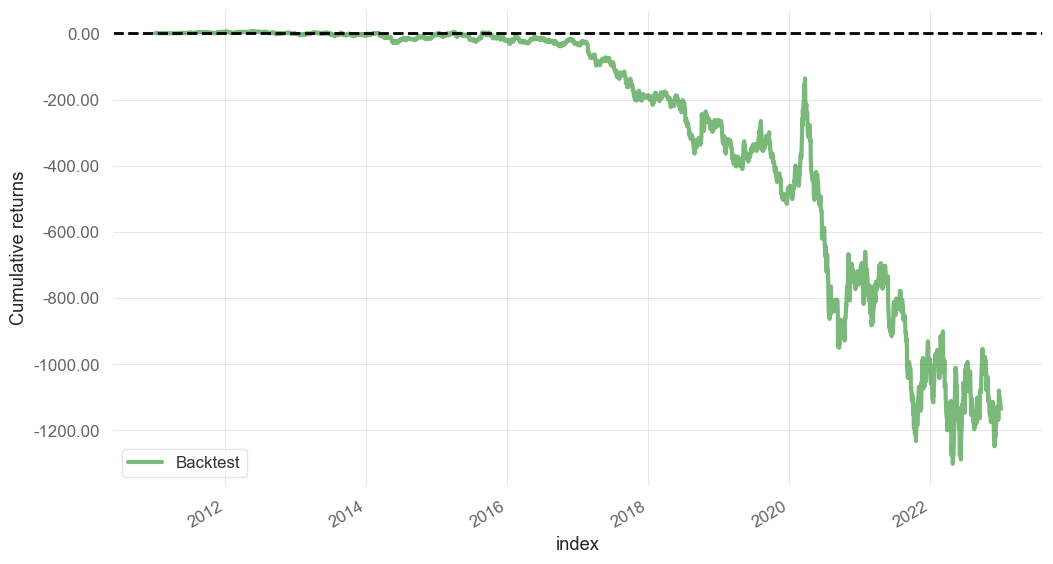

In [24]:
class ORBStrategy(bt.Strategy):
    params = (
        ("entry_length", 30),
        ("stop_loss", 1),
        ("take_profit", 3),
    )

    def __init__(self):
        self.order = None
        self.entry = None
        self.stop_loss = None
        self.take_profit = None

    def next(self):
        if not self.position:
            self.entry = self.data.high[0] if self.data.open[0] < self.data.close[0] else self.data.low[0]
            self.stop_loss = self.entry - self.params.stop_loss
            self.take_profit = self.entry + self.params.take_profit
            self.order = self.buy()
        elif self.data.close[0] < self.stop_loss:
            self.order = self.sell()
        elif self.data.close[0] > self.take_profit:
            self.order = self.sell()
                
if __name__ == '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    cerebro.addstrategy(ORBStrategy)
    
    # Create a Data Feed
    data = bt.feeds.YahooFinanceCSVData(
        dataname='Notebooks/Reliance strategies/reliance_15min_data.csv',
        # Do not pass values before this date
        fromdate=datetime.datetime(2011, 1, 3),
        # Do not pass values before this date
        todate=datetime.datetime(2023, 1, 3),
        # Do not pass values after this date
        reverse=False)

    # Add the Data Feed to Cerebro
    cerebro.adddata(data)

    # Set our desired cash start
    cerebro.broker.setcash(100000.0)

    # Set the commission
    cerebro.broker.setcommission(commission=0.0)

    # Print out the starting conditions
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Create an instance of an Analyzer subclass and add it to the Cerebro object
    cerebro.addanalyzer(bt.analyzers.SharpeRatio)

    # Run over everything
    cerebro.run()

    # Print out the final result
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())

    cerebro.addanalyzer(bt.analyzers.PyFolio, _name='PyFolio')
    results = cerebro.run()
    strat = results[0]
    portfolio_stats = strat.analyzers.getbyname('PyFolio')
    returns, positions, transactions, gross_lev = portfolio_stats.get_pf_items()
    returns.index = returns.index.tz_convert(None)

    quantstats.reports.html(returns, output='stats.html', title='Reliance ORB')
    '''data = cerebro.plot()
    data[0][0].savefig("orb.png")'''

    pf.plotting.plot_rolling_returns(returns)